In [405]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score, recall_score, precision_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#Read the data
# data=pd.read_csv('A04 FILA 20A_output_stem_trackable_objects.csv')
# data.head()
# data=pd.read_excel('Copy A04 FILA 20A_output_stem_trackable_objects.xlsx')
# data=pd.read_excel('Copy A04 FILA 01B_output_stem_trackable_objects.xlsx')
# data=pd.read_excel("Copy p22_h44_lado_B_output_stem_trackable_objects.xlsx")
data=pd.read_excel('Copy A04 FILA 10A_output_stem_trackable_objects.xlsx')


data.head()

,object_id,centroids_x,centroids_y,aspect_ratio,area,frames,scores,counted,ground_truth
0,113,22,1386,0.000000e+00,0.0,129,0.13,False,False
1,113,84,1405,2.708075e+16,70196.0,140,0.11,False,False
2,113,85,1406,2.607843e+15,61047.0,141,0.12,False,False
3,113,71,1428,2.484615e+16,41990.0,142,0.57,False,False
4,113,55,1467,2.666667e+16,26136.0,143,0.77,False,False


In [407]:
#Get the number of frames for each object

frame_counts = data.groupby('object_id')['frames'].apply(lambda x: x.max() - x.min())

In [408]:
frame_info=data.groupby('object_id')['frames'].min()

In [409]:
stems=data['object_id'].unique()

In [410]:
#Get the velocity for each object and observation
def assign_velocities(df):
    
    def compute_vel(group):
        # Compute velocity as the difference in centroids_x over difference in frames
        vel = group['centroids_x'].diff() / group['frames'].diff()
        # Replace the first observation (NaN) with the group's mean velocity
        if not vel.empty:
            vel.iloc[0] = vel.mean()  # .mean() ignores NaN by default
        return vel

    # Use groupby to apply compute_vel for each object_id
    df['velocity'] = df.groupby('object_id', group_keys=False)[['centroids_x','frames']].apply(compute_vel)
    return df

assign_velocities(data);

In [411]:
if data['velocity'].mean()<0:
    data['velocity']=-data['velocity']

In [412]:
data

,object_id,centroids_x,centroids_y,aspect_ratio,area,frames,scores,counted,ground_truth,velocity
0,113,22,1386,0.000000e+00,0.0,129,0.13,False,False,7.560606
1,113,84,1405,2.708075e+16,70196.0,140,0.11,False,False,-5.636364
2,113,85,1406,2.607843e+15,61047.0,141,0.12,False,False,-1.000000
3,113,71,1428,2.484615e+16,41990.0,142,0.57,False,False,14.000000
4,113,55,1467,2.666667e+16,26136.0,143,0.77,False,False,16.000000
...,...,...,...,...,...,...,...,...,...,...
2990,5131,711,1291,1.673684e+16,740145.0,4532,0.65,False,False,51.000000
2991,5131,646,1214,1.833605e+15,689012.0,4533,0.51,False,False,65.000000
2992,5131,613,1127,1.952066e+16,714505.0,4534,0.59,False,False,33.000000
2993,5131,575,1026,2.179924e+15,607728.0,4535,0.19,False,False,38.000000


In [413]:
#Replace the 'frames' column with the number of frames for each object
#data['frame']=data['frames']
data['frames']=[frame_counts.get(data.loc[i,'object_id']) for i in range(len(data))]
data['first_frame']=[frame_info.get(data.loc[i,'object_id']) for i in range(len(data))]
data['mean_velocity_fps']=[data.groupby('object_id')['velocity'].mean().get(data.loc[i,'object_id']) for i in range(len(data))]
data['std_area']=[data.groupby('object_id')['area'].std().get(data.loc[i,'object_id']) for i in range(len(data))]
data['adj_std_area']=data['std_area']/data['frames']
data.head()

,object_id,centroids_x,centroids_y,aspect_ratio,area,frames,scores,counted,ground_truth,velocity,first_frame,mean_velocity_fps,std_area,adj_std_area
0,113,22,1386,0.000000e+00,0.0,16,0.13,False,False,7.560606,129,7.560606,26155.700543,1634.731284
1,113,84,1405,2.708075e+16,70196.0,16,0.11,False,False,-5.636364,129,7.560606,26155.700543,1634.731284
2,113,85,1406,2.607843e+15,61047.0,16,0.12,False,False,-1.000000,129,7.560606,26155.700543,1634.731284
3,113,71,1428,2.484615e+16,41990.0,16,0.57,False,False,14.000000,129,7.560606,26155.700543,1634.731284
4,113,55,1467,2.666667e+16,26136.0,16,0.77,False,False,16.000000,129,7.560606,26155.700543,1634.731284


In [414]:
data.describe()

,object_id,centroids_x,centroids_y,aspect_ratio,area,frames,scores,velocity,first_frame,mean_velocity_fps,std_area,adj_std_area
count,2995.000000,2995.000000,2995.000000,2.995000e+03,2995.000000,2995.000000,2995.000000,2980.000000,2995.000000,2980.000000,2980.000000,2980.000000
mean,2333.507513,565.050083,1132.727546,1.153569e+16,190198.101836,51.896828,0.705209,18.490690,2210.015025,18.490690,69961.847910,2771.934182
std,1431.611664,318.058335,133.014753,1.565959e+16,122618.836098,23.384754,0.205850,15.098218,1308.748555,6.940194,45619.461843,10715.997084
min,113.000000,10.000000,604.000000,0.000000e+00,0.000000,0.000000,0.100000,-44.000000,129.000000,-4.500000,5650.426850,263.836351
25%,1058.000000,288.000000,1057.000000,3.900934e+15,118863.000000,39.000000,0.625000,8.000000,1068.000000,15.138462,36677.781780,623.347314
50%,2192.000000,588.000000,1131.000000,5.753247e+15,170136.000000,53.000000,0.780000,17.000000,2099.000000,17.683362,50970.492739,1125.519942
75%,3488.000000,854.500000,1203.000000,8.698625e+15,236065.500000,64.000000,0.860000,27.000000,3371.000000,21.355556,87096.347093,2474.562662
max,5147.000000,1054.000000,1784.000000,7.990741e+16,740145.000000,111.000000,0.950000,100.000000,4516.000000,51.500000,290224.420270,229894.556699


In [415]:
len(data[data['counted']==1].groupby('object_id'))

56

In [416]:
#Get only the objects that have been counted

# stems=data.groupby('object_id').mean()
positive_stems=data[data['counted']==1].reset_index(drop=True)
positive_stems['ground_truth']=positive_stems['ground_truth'].map({'True Positive':1,'False Positive':0}).astype(bool)
# positive_stems=stems[stems['counted']==1]


In [417]:
accuracy_score(positive_stems['ground_truth'],positive_stems['counted'])

0.9349624060150376

In [418]:
positive_stems.drop('counted',axis=1,inplace=True)

In [419]:
positive_stems.groupby('object_id').mean()

,centroids_x,centroids_y,aspect_ratio,area,frames,scores,ground_truth,velocity,first_frame,mean_velocity_fps,std_area,adj_std_area
object_id,,,,,,,,,,,,
189,547.017857,1028.982143,1.410350e+16,143038.517857,58.0,0.466786,1.0,16.451515,191.0,16.451515,54173.336845,934.023049
272,577.451613,1025.225806,1.480127e+16,231825.258065,63.0,0.625484,0.0,15.808743,272.0,15.808743,81803.274453,1298.464674
293,581.363636,861.363636,2.269580e+16,233630.181818,13.0,0.841818,1.0,18.500000,285.0,18.500000,79211.890037,6093.222311
377,526.788462,1128.038462,1.280530e+16,137822.269231,52.0,0.513269,1.0,19.725490,371.0,19.725490,27399.807028,526.919366
412,496.000000,1159.750000,5.107887e+15,121315.000000,10.0,0.645000,1.0,19.607143,398.0,19.607143,53478.307276,5347.830728
478,512.431034,1101.155172,8.510859e+15,157042.224138,62.0,0.617241,1.0,16.778947,450.0,16.778947,47916.055717,772.839608
606,532.716049,1116.654321,1.175496e+16,88282.222222,83.0,0.780247,1.0,12.965625,551.0,12.965625,29133.196677,351.002370
690,571.134615,1088.019231,8.861766e+15,119060.134615,51.0,0.791731,1.0,19.941176,659.0,19.941176,31825.409840,624.027644
787,490.000000,1222.338462,8.633906e+15,105119.000000,77.0,0.670615,1.0,16.089286,785.0,16.089286,35028.299683,454.912983


In [420]:
#Get the distance between positive detections

first_frame_pos=positive_stems.groupby('object_id').mean()
first_frame_pos['dist_between_apps']=[first_frame_pos.iloc[0,8] if i==0 else first_frame_pos.iloc[i,8]-first_frame_pos.iloc[i-1,8] for i in range(len(first_frame_pos))]
first_frame_pos.iat[0,-1]=first_frame_pos['dist_between_apps'].median()

# first_frame_pos

In [421]:
first_frame_pos

,centroids_x,centroids_y,aspect_ratio,area,frames,scores,ground_truth,velocity,first_frame,mean_velocity_fps,std_area,adj_std_area,dist_between_apps
object_id,,,,,,,,,,,,,
189,547.017857,1028.982143,1.410350e+16,143038.517857,58.0,0.466786,1.0,16.451515,191.0,16.451515,54173.336845,934.023049,78.0
272,577.451613,1025.225806,1.480127e+16,231825.258065,63.0,0.625484,0.0,15.808743,272.0,15.808743,81803.274453,1298.464674,81.0
293,581.363636,861.363636,2.269580e+16,233630.181818,13.0,0.841818,1.0,18.500000,285.0,18.500000,79211.890037,6093.222311,13.0
377,526.788462,1128.038462,1.280530e+16,137822.269231,52.0,0.513269,1.0,19.725490,371.0,19.725490,27399.807028,526.919366,86.0
412,496.000000,1159.750000,5.107887e+15,121315.000000,10.0,0.645000,1.0,19.607143,398.0,19.607143,53478.307276,5347.830728,27.0
478,512.431034,1101.155172,8.510859e+15,157042.224138,62.0,0.617241,1.0,16.778947,450.0,16.778947,47916.055717,772.839608,52.0
606,532.716049,1116.654321,1.175496e+16,88282.222222,83.0,0.780247,1.0,12.965625,551.0,12.965625,29133.196677,351.002370,101.0
690,571.134615,1088.019231,8.861766e+15,119060.134615,51.0,0.791731,1.0,19.941176,659.0,19.941176,31825.409840,624.027644,108.0
787,490.000000,1222.338462,8.633906e+15,105119.000000,77.0,0.670615,1.0,16.089286,785.0,16.089286,35028.299683,454.912983,126.0


In [422]:
#Include the distance between first tracking in the dataframe
positive_stems['dist_between_apps']=[first_frame_pos['dist_between_apps'].get(positive_stems.loc[i,'object_id']) for i in range(len(positive_stems))]
positive_stems.drop('first_frame',axis=1,inplace=True)
# positive_stems

In [423]:
#Inlcude the frames persisted adjusted by the relative speed of each stem
normalized_speed=MinMaxScaler().fit_transform(pd.DataFrame(positive_stems['mean_velocity_fps']))

positive_stems['adjusted_frames']=[positive_stems['frames'][i]*normalized_speed[i][0] for i in range(len(normalized_speed))]

In [424]:
# positive_stems.groupby('object_id').mean()

In [425]:
positive_stems['preds']=1

In [426]:
# Reorganize columns so that 'ground_truth' and 'preds' are the second to last and last columns
columns = [col for col in positive_stems.columns if col not in ['ground_truth', 'preds']] + ['ground_truth', 'preds']
positive_stems = positive_stems[columns]
# positive_stems.head()

In [427]:
positive_stems['scores'].quantile(0.1), positive_stems['frames'].quantile(0.2), positive_stems['adjusted_frames'].quantile(0.2)

(0.45, 40.0, 6.95157157068063)

In [428]:
positive_stems['frames'].quantile(0.01), positive_stems['adjusted_frames'].quantile(0.05), positive_stems['dist_between_apps'].quantile(0.2)

(13.0, 3.442705759162304, 64.0)

In [429]:
positive_stems['area'].quantile(0.2), positive_stems['area'].quantile(0.8), positive_stems['aspect_ratio'].quantile(0.2)

(118691.6, 270845.60000000003, 3407380700986322.0)

In [430]:
positive_stems.describe()

,object_id,centroids_x,centroids_y,aspect_ratio,area,frames,scores,velocity,mean_velocity_fps,std_area,adj_std_area,dist_between_apps,adjusted_frames,preds
count,2660.000000,2660.000000,2660.000000,2.660000e+03,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.000000,2660.0
mean,2364.739850,570.776692,1135.718045,1.169445e+16,199722.517293,56.841729,0.729500,18.936504,18.936504,69390.596161,1608.073005,85.745865,12.455853,1.0
std,1372.852378,307.241788,107.152369,1.570336e+16,116628.152887,19.701747,0.186926,15.019455,6.076426,41668.076687,2553.817028,27.103358,5.274979,0.0
min,189.000000,10.000000,649.000000,0.000000e+00,0.000000,5.000000,0.100000,-44.000000,10.349686,26944.042598,263.836351,13.000000,0.000000,1.0
25%,1194.000000,320.000000,1065.000000,4.039126e+15,130491.750000,43.000000,0.670000,9.000000,15.333333,36824.877913,566.536583,67.000000,9.189782,1.0
50%,2302.000000,586.000000,1135.000000,5.757087e+15,175203.500000,54.000000,0.800000,17.000000,17.811321,54069.130885,983.075107,85.000000,13.087401,1.0
75%,3488.000000,846.000000,1201.000000,8.567575e+15,242893.500000,65.000000,0.860000,27.000000,21.584470,87096.347093,1997.005443,101.000000,15.661508,1.0
max,5033.000000,1052.000000,1656.000000,7.990741e+16,738816.000000,111.000000,0.950000,100.000000,41.583333,290224.420270,58044.884054,143.000000,24.000000,1.0


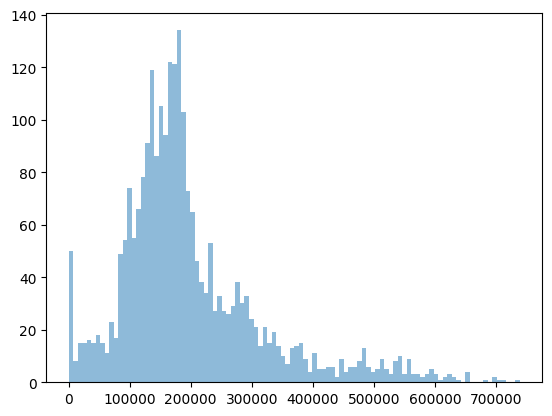

In [431]:
tp=positive_stems[positive_stems['ground_truth']==1]
fp=positive_stems[positive_stems['ground_truth']==0]

plt.hist(tp['area'], bins=100, alpha=0.5, label='True Positives Area')
plt.show()

In [432]:
tp['area'].std(), fp['area'].std()

(118101.15990874547, 90867.43370105697)

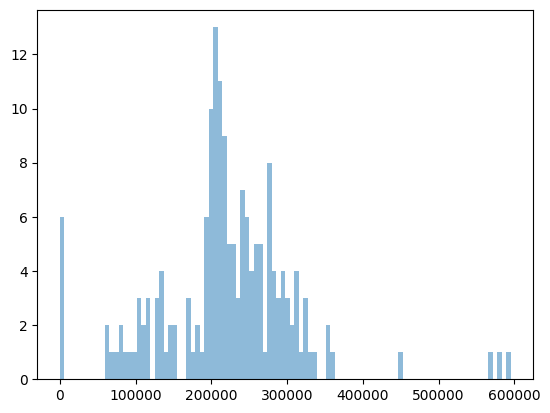

In [433]:
plt.hist(fp['area'], bins=100, alpha=0.5, label='False Positives Area')
plt.show()

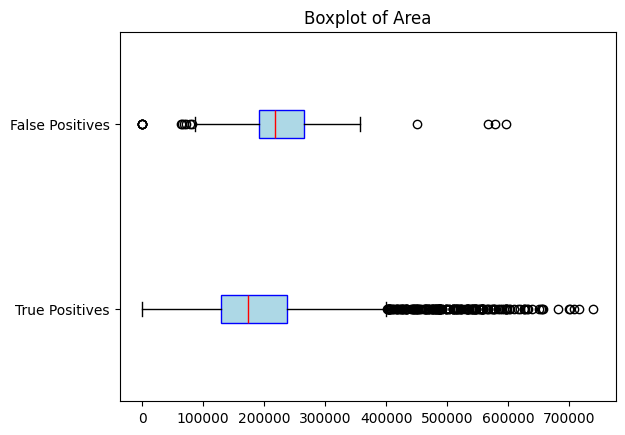

In [434]:
plt.boxplot([tp['area'],fp['area']], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'), labels=['True Positives', 'False Positives'])
plt.title('Boxplot of Area')
plt.show()

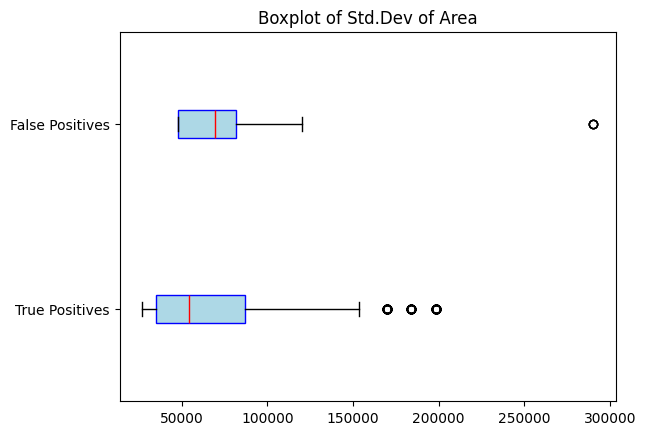

In [435]:
plt.boxplot([tp['std_area'],fp['std_area']], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'), labels=['True Positives', 'False Positives'])
plt.title('Boxplot of Std.Dev of Area')
plt.show()

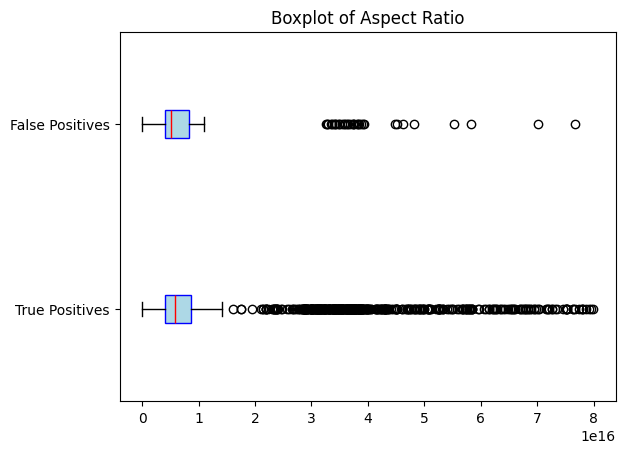

In [436]:
plt.boxplot([tp['aspect_ratio'],fp['aspect_ratio']], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='blue'), medianprops=dict(color='red'), labels=['True Positives', 'False Positives'])
plt.title('Boxplot of Aspect Ratio')
plt.show()

In [437]:
#Filter the observations that according to the statistics could be false positives
for i in range(len(positive_stems)):

    #Start by assigning -1 to oddly low object values

    #Check first for low frames and adjusted frames and low scores
    if positive_stems['frames'][i]<positive_stems['frames'].quantile(0.2) and positive_stems['adjusted_frames'][i]<positive_stems['adjusted_frames'].quantile(0.2) and positive_stems['scores'][i]<positive_stems['scores'].quantile(0.1):
        positive_stems.at[i,'preds']=-1
    
    #Check for very low frames and very low adjusted frames
    if (positive_stems['frames'][i]<positive_stems['frames'].quantile(0.05) and positive_stems['adjusted_frames'][i]<positive_stems['adjusted_frames'].quantile(0.05)):
        positive_stems.at[i,'preds']=-1

    #Check for low distance between apps and low scores or low frames
    if positive_stems['dist_between_apps'][i]<positive_stems['dist_between_apps'].quantile(0.2) and positive_stems['scores'][i]<positive_stems['scores'].quantile(0.15):# or positive_stems['frames'][i]<positive_stems['frames'].quantile(0.05)):
        positive_stems.at[i,'preds']=-1

    #Check for low velocity and low scores
    if positive_stems['velocity'][i]<positive_stems['velocity'].median() and positive_stems['scores'][i]<positive_stems['scores'].quantile(0.1):
        positive_stems.at[i,'preds']=-1

    #Check for high adjusted std area and low scores
    if positive_stems['adj_std_area'][i]>positive_stems['adj_std_area'].quantile(0.8) and positive_stems['scores'][i]<positive_stems['scores'].quantile(0.1):
        positive_stems.at[i,'preds']=-1

    #Check for low adjusted std area and high scores
    if positive_stems['adj_std_area'][i]<positive_stems['adj_std_area'].quantile(0.2) and positive_stems['scores'][i]>positive_stems['scores'].quantile(0.1):
        positive_stems.at[i,'preds']=1

In [438]:
with pd.option_context('display.max_rows', None):
    display(positive_stems.groupby('object_id').mean())

,centroids_x,centroids_y,aspect_ratio,area,frames,scores,velocity,mean_velocity_fps,std_area,adj_std_area,dist_between_apps,adjusted_frames,ground_truth,preds
object_id,,,,,,,,,,,,,,
189,547.017857,1028.982143,1.410350e+16,143038.517857,58.0,0.466786,16.451515,16.451515,54173.336845,934.023049,78.0,11.330924,1.0,0.607143
272,577.451613,1025.225806,1.480127e+16,231825.258065,63.0,0.625484,15.808743,15.808743,81803.274453,1298.464674,81.0,11.011221,0.0,0.483871
293,581.363636,861.363636,2.269580e+16,233630.181818,13.0,0.841818,18.500000,18.500000,79211.890037,6093.222311,13.0,3.392306,1.0,-1.000000
377,526.788462,1128.038462,1.280530e+16,137822.269231,52.0,0.513269,19.725490,19.725490,27399.807028,526.919366,86.0,15.609506,1.0,0.961538
412,496.000000,1159.750000,5.107887e+15,121315.000000,10.0,0.645000,19.607143,19.607143,53478.307276,5347.830728,27.0,2.963937,1.0,-1.000000
478,512.431034,1101.155172,8.510859e+15,157042.224138,62.0,0.617241,16.778947,16.778947,47916.055717,772.839608,52.0,12.762333,1.0,0.448276
606,532.716049,1116.654321,1.175496e+16,88282.222222,83.0,0.780247,12.965625,12.965625,29133.196677,351.002370,101.0,6.951572,1.0,0.901235
690,571.134615,1088.019231,8.861766e+15,119060.134615,51.0,0.791731,19.941176,19.941176,31825.409840,624.027644,108.0,15.661508,1.0,1.000000
787,490.000000,1222.338462,8.633906e+15,105119.000000,77.0,0.670615,16.089286,16.089286,35028.299683,454.912983,126.0,14.149778,1.0,0.846154


In [439]:
# positive_stems[positive_stems['object_id']==4351]
#positive_stems[positive_stems['object_id']==6760]